In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tcn.tcn import TCN
from tensorflow import keras

from sklearn.metrics import mean_squared_error


In [2]:
# 定义几个全局变量
window_size = 10   # 窗口大小
batch_size = 32    # 训练批次大小
epochs = 200       # 训练epoch
filter_nums = 10   # filter数量
kernel_size = 4    # kernel大小

In [3]:
# data
df_train = pd.read_csv("Train.csv")
df_train['Datetime'] = pd.to_datetime(df_train.Datetime, format='%Y/%m/%d')
df_test = pd.read_csv("Test.csv")
df_test['Datetime'] = pd.to_datetime(df_test.Datetime, format='%Y/%m/%d')

train = np.asarray(df_train.iloc[:,1])
test = np.asarray(df_test.iloc[:,1])
# 此时train和test都是ndarray

In [4]:
def get_dataset():
    data = np.concatenate((train,test), axis=0)
    
    scaler = MinMaxScaler()  #归一化

    sep = len(train)
    open_arr = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)
    
    X = np.zeros(shape=(len(open_arr) - window_size, window_size))  # 长是len-10，宽是10；
    label = np.zeros(shape=(len(open_arr) - window_size))  # 长是len-10
    for i in range(len(open_arr) - window_size):
        X[i, :] = open_arr[i:i+window_size]  # X第i行 = 原数据i到i+10（取不到10）的值
        label[i] = open_arr[i+window_size]  # label[i] = 原数据i+10的值，X正好取不到
    
    train_X = X[:sep, :]  # 前面的数据用来训练
    train_label = label[:sep]
    test_X = X[sep-window_size:, :]  # 后面的数据用来测试
    test_label = label[sep-window_size:]
    return train_X, train_label, test_X, test_label, scaler


In [5]:
train_X, train_label, test_X, test_label, scaler = get_dataset()

In [6]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size, 1)),
    TCN(nb_filters=filter_nums,     # 滤波器的个数，类比于units
        kernel_size=kernel_size,    # 卷积核的大小
        dilations=[1, 2, 4, 8]),    # 空洞因子
    keras.layers.Dense(units=1, activation='relu')
])
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.fit(train_X, train_label, validation_split=0.2, epochs=epochs)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 10)                2940      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 2,951
Trainable params: 2,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
72/72 [==============================] - 8s 44ms/step - loss: 2.6468 - mse: 2.6468 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 2/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 3/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 4/200
72/72 [==============================] - 1s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0093 - val_

72/72 [==============================] - 1s 10ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 119/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 120/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 121/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 122/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 123/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 124/200
72/72 [==============================] - 1s 10ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 125/200
72/72 [==============================] - 1s 10ms/step - loss: 

In [9]:
model.evaluate(test_X, test_label)

fit = model.predict(train_X)

prediction = model.predict(test_X)
tcn_pre = scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)
tcn_fit = scaler.inverse_transform(fit.reshape(-1, 1)).reshape(-1)
# 反变换
print('mse of TCN: ', mean_squared_error(tcn_pre, test))
# 39.76533075960535

23/23 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
mse of TCN:  39.76533075960535


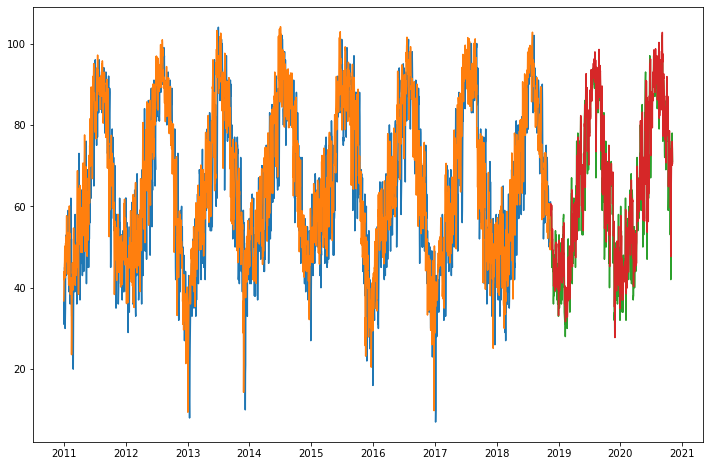

In [10]:
plt.figure(figsize=(12, 8))  # large picture
plt.plot(df_train.Datetime, train, label='Train')
plt.plot(df_train.Datetime, tcn_fit, label='TCN fit')
plt.plot(df_test.Datetime, test, label='Test')
plt.plot(df_test.Datetime, tcn_pre, label='TCN prediction')
plt.show()

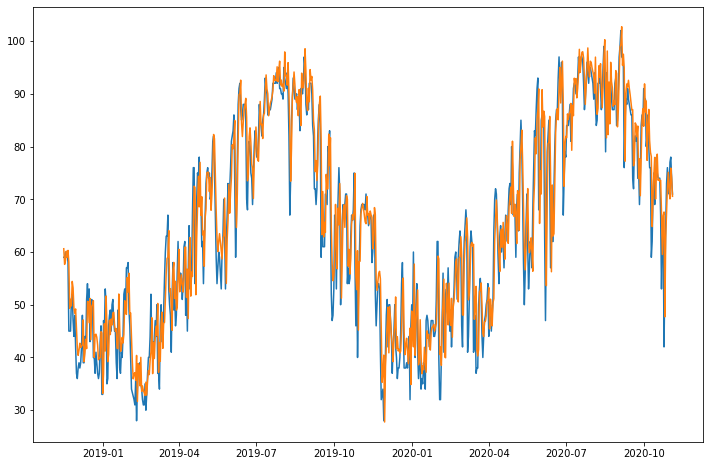

In [12]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
# plt.plot(df_train.Datetime, train[predictname], label='train')
plt.plot(df_test.Datetime, test, label='Test')
plt.plot(df_test.Datetime, scaled_prediction, label='TCN')
plt.show()

In [15]:
pd.DataFrame(np.concatenate([tcn_fit,tcn_pre])).to_csv('result_TCN.csv',index = False)
# 预测的结果，有预测值和拟合值